# Feature Engineering vs. Model Complexity in Time Series Forecasting

This notebook supports the article **“Stop Blaming Your Model: How Feature Engineering Wins More Than You Think.”**

The goal is to show, on a synthetic but realistic daily time series, how much improvement you can get from **systematic feature engineering** before changing the model class. We:

1. Generate a structured time series with trend, weekly patterns, annual seasonality, and holiday effects.  
2. Explore the structure visually.  
3. Define a 14-day-ahead forecasting task.  
4. Engineer calendar, cyclic, lag, and rolling features.  
5. Compare three approaches with the **same model family (XGBoost)**:
   - Naive persistence baseline  
   - XGBoost with weak features  
   - XGBoost with rich engineered features  

All code in this notebook is self-contained and can be run end-to-end.

In [1]:
# 0. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")  # optional
np.random.seed(42)

## 1. Synthetic time series construction

To keep the example reproducible and non-proprietary, we generate our own daily time series. The objective is not to create a toy sine wave, but a series that behaves like a typical operational metric (e.g., demand, usage, or traffic):

- A **slow upward trend** to capture long-term growth.  
- A **weekly pattern** (weekdays vs weekends).  
- **Annual seasonality** (some months systematically higher).  
- **Holiday shocks** (sharp spikes on a few calendar dates).  

This lets us control the ground-truth structure while still exercising the same feature-engineering instincts you would use on a real business dataset.


In [2]:
# 1. Generate synthetic daily time series

n_years = 5
start_date = "2015-01-01"
dates = pd.date_range(start=start_date, periods=365 * n_years, freq="D")

df = pd.DataFrame(index=dates)
n = len(df)
t = np.arange(n)

# Trend: slow upward drift
trend = 0.001 * t

# Weekly pattern: Mon–Sun
weekly_pattern = np.array([1.0, 1.1, 1.2, 1.15, 1.05, 0.8, 0.75])
weekly = weekly_pattern[df.index.dayofweek]

# Annual pattern: simple smooth seasonality
day_of_year = df.index.dayofyear
annual = 0.3 * np.sin(2 * np.pi * day_of_year / 365.25)

# Base value
base_level = 5.0

# Combine components and add noise
noise = np.random.normal(scale=0.3, size=n)

df["value"] = base_level + trend + weekly + annual + noise

### 1.1 Holiday effects

Here we inject a few fixed holidays (e.g. Jan 1, Jul 4, Dec 25) and add positive shocks on those dates. In real energy or traffic data, holidays often create large deviations from the usual weekly pattern. Modeling these explicitly is one of the places where feature engineering typically pays off.


In [3]:
# 1.1 Add holiday effects (spikes / dips on a few fixed dates)

holidays = [(1, 1), (7, 4), (12, 25)]  # (month, day)
is_holiday = np.zeros(n, dtype=bool)

for year in range(df.index.year.min(), df.index.year.max() + 1):
    for month, day in holidays:
        dt = pd.Timestamp(year=year, month=month, day=day)
        if dt in df.index:
            is_holiday[df.index.get_loc(dt)] = True

df["is_holiday"] = is_holiday.astype(int)

# Add positive shocks on holidays
holiday_shock_mean = 2.0
holiday_shock_std = 0.5

df.loc[df["is_holiday"] == 1, "value"] += np.random.normal(
    loc=holiday_shock_mean,
    scale=holiday_shock_std,
    size=df["is_holiday"].sum()
)

df.head()

,value,is_holiday
2015-01-01,8.525145,1
2015-01-02,6.019840,0
2015-01-03,6.011782,0
2015-01-04,6.230536,0
2015-01-05,5.959526,0


## 2. Exploratory analysis of the synthetic series

Before building any model, we look at the basic structure of the series:

- A full time-series plot to sanity-check the overall level, trend, and variability.  
- A zoomed-in window to see weekly behavior and holiday spikes.  
- Aggregations by **day of week** and **month** to confirm the calendar patterns we built in.  

In a real project, this is the stage where you build intuition for which features are worth engineering and which patterns are likely to matter for the forecast.


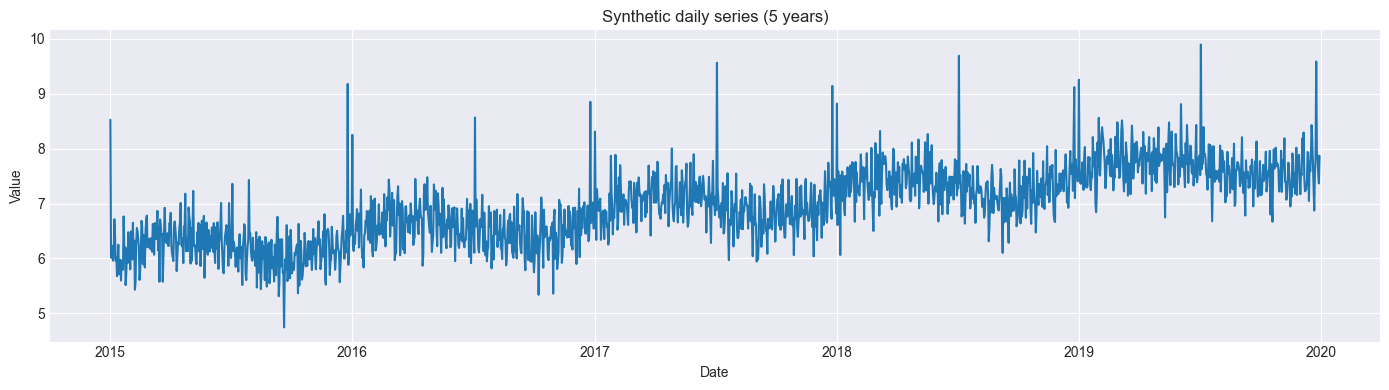

In [4]:
# 2.1 Full series plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df.index, df["value"])
ax.set_title("Synthetic daily series (5 years)")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
plt.tight_layout()

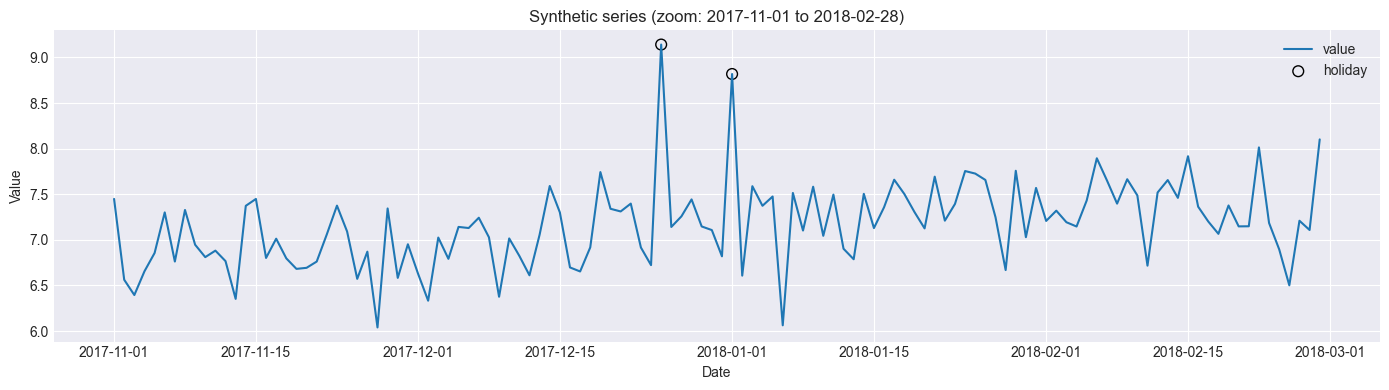

In [5]:
# 2.2 Zoom in on a few months to show weekly pattern and holiday spikes

zoom_start = "2017-11-01"
zoom_end = "2018-02-28"
df_zoom = df.loc[zoom_start:zoom_end]

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_zoom.index, df_zoom["value"], label="value")
ax.scatter(
    df_zoom.index[df_zoom["is_holiday"] == 1],
    df_zoom.loc[df_zoom["is_holiday"] == 1, "value"],
    marker="o",
    s=60,
    edgecolor="k",
    facecolor="none",
    label="holiday"
)
ax.set_title(f"Synthetic series (zoom: {zoom_start} to {zoom_end})")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.tight_layout()

C:\Users\ZackaryS\AppData\Local\Temp\ipykernel_24224\2907686865.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


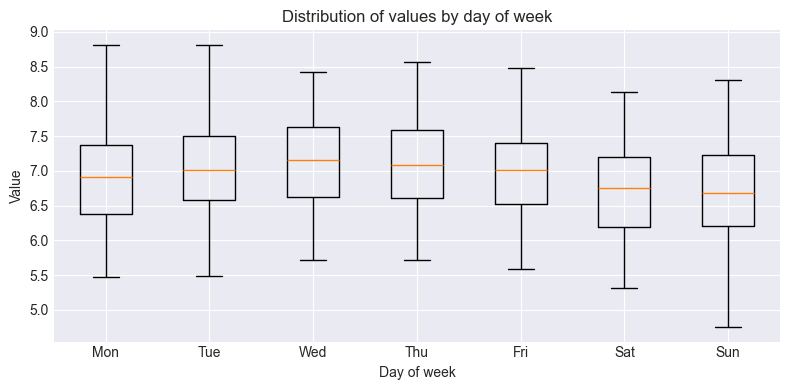

In [6]:
# 2.3 Day-of-week effect

df["day_of_week"] = df.index.dayofweek  # 0=Mon, 6=Sun
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(
    [df.loc[df["day_of_week"] == i, "value"] for i in range(7)],
    labels=dow_labels,
    showfliers=False
)
ax.set_title("Distribution of values by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Value")
plt.tight_layout()

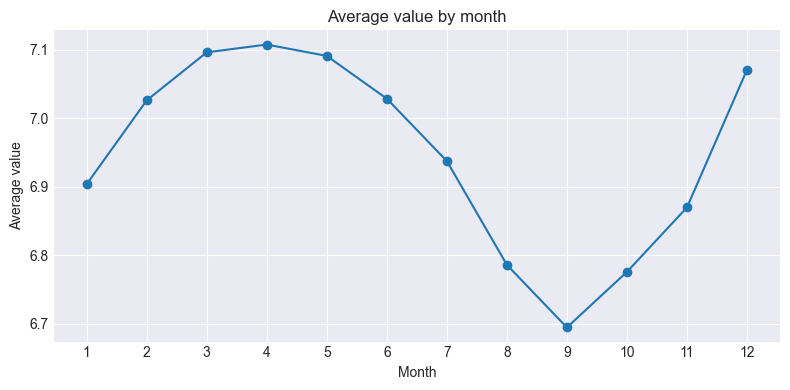

In [7]:
# 2.4 Average by month (annual pattern)

df["month"] = df.index.month

monthly_mean = df.groupby("month")["value"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(monthly_mean.index, monthly_mean.values, marker="o")
ax.set_xticks(range(1, 13))
ax.set_xlabel("Month")
ax.set_ylabel("Average value")
ax.set_title("Average value by month")
plt.tight_layout()

## 3. Forecasting task definition

We frame the problem as a **14-day-ahead** forecast:

- Input at time *t*: all information available up to day *t*.  
- Target at time *t*: the series value on day *t + 14*.  

This is enough to illustrate the effect of feature engineering without getting bogged down in horizon-specific leakage issues. All splits are done by **time** (train → validation → test), not by random shuffling.


In [8]:
# 3. Forecasting task: 14-day-ahead prediction
horizon = 14  # keep it simple and leak-free for the article

df["target"] = df["value"].shift(-horizon)

# Drop last horizon rows with no target
df = df.iloc[:-horizon].copy()

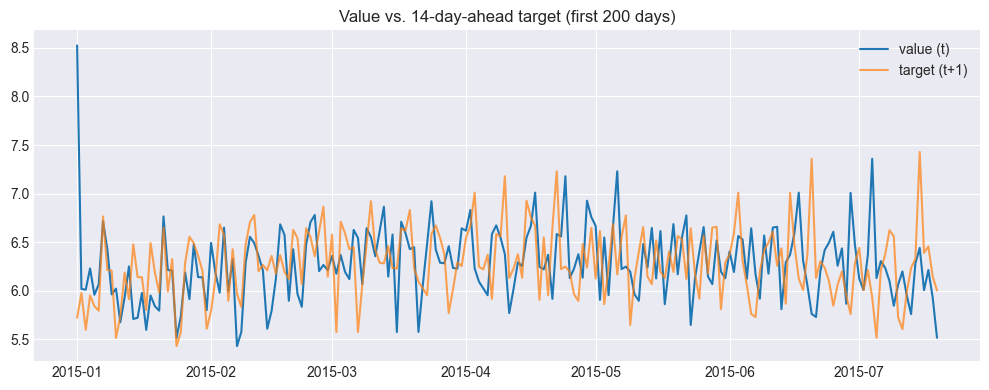

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index[:200], df["value"].iloc[:200], label="value (t)")
ax.plot(df.index[:200], df["target"].iloc[:200], label="target (t+1)", alpha=0.7)
ax.set_title("Value vs. 14-day-ahead target (first 200 days)")
ax.legend()
plt.tight_layout()

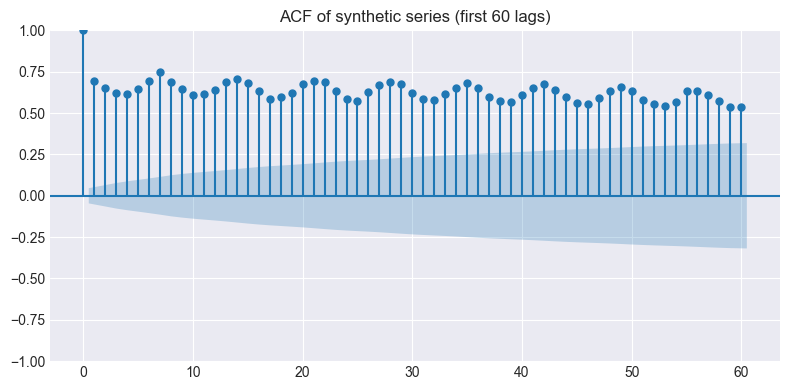

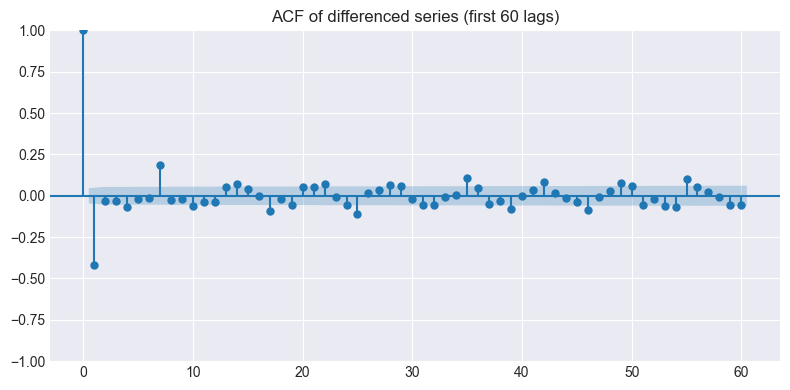

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# Option 1: raw series, short lags
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(df["value"], lags=60, ax=ax)
ax.set_title("ACF of synthetic series (first 60 lags)")
plt.tight_layout()

# Option 2 (cleaner): difference to remove trend, then ACF
df["diff_value"] = df["value"].diff()
df_diff = df["diff_value"].dropna()

fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(df_diff, lags=60, ax=ax)
ax.set_title("ACF of differenced series (first 60 lags)")
plt.tight_layout()

In [11]:
# 3. Forecasting task: 14-day-ahead prediction
horizon = 14

df["target"] = df["value"].shift(-horizon)

# Drop last horizon rows with no target
df = df.iloc[:-horizon].copy()

In [12]:
# 3.1 Train/validation/test split by time
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]

len(df_train), len(df_val), len(df_test)

(1078, 359, 360)

## 4. Feature engineering

Next we construct two sets of features:

1. A **weak feature set** that mimics a quick-and-dirty baseline:
   - A couple of lagged values (e.g. `lag_1`, `lag_7`)  
   - A simple integer `day_index`  

2. A **richer feature set** that encodes what we know about the structure of the series:
   - Calendar indicators: day of week, month, `is_weekend`, `is_holiday`  
   - **Cyclic encodings** (sine/cosine) for day-of-week and month, to respect their circular nature  
   - Additional lags (e.g. `lag_14`)  
   - **Rolling statistics** (7-day and 30-day rolling means and standard deviations), computed in a leakage-safe way using only past data  

The model class will remain fixed. Only the feature space changes.


In [13]:
# 4. Feature engineering

# Calendar features
df["day_of_week"] = df.index.dayofweek  # 0=Mon ... 6=Sun
df["month"] = df.index.month
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

# Cyclic encodings
df["dow_sin"]   = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["dow_cos"]   = np.cos(2 * np.pi * df["day_of_week"] / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Lag features – all past values relative to forecast origin
for lag in [1, 7, 14, ]:
    df[f"lag_{lag}"] = df["value"].shift(lag)

# Rolling statistics (leakage-safe: shift after rolling)
for win in [7, 30]:
    df[f"roll_mean_{win}"] = df["value"].rolling(win).mean().shift(1)
    df[f"roll_std_{win}"]  = df["value"].rolling(win).std().shift(1)

# Simple day index
df["day_index"] = np.arange(len(df))

# Drop initial rows that now contain NaNs from lags/rolls
df = df.dropna().copy()

# Re-split after dropping NaNs (important!)
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]

y_train = df_train["target"].values
y_val   = df_val["target"].values
y_test  = df_test["target"].values

df_train.head()

,value,is_holiday,day_of_week,month,target,diff_value,is_weekend,dow_sin,dow_cos,month_sin,month_cos,lag_1,lag_7,lag_14,roll_mean_7,roll_std_7,roll_mean_30,roll_std_30,day_index
2015-01-31,5.801995,0,5,1,5.610167,-0.337537,1,-0.974928,-0.222521,0.500000,0.866025,6.139532,5.515944,5.598638,6.016340,0.319743,6.123595,0.542297,30
2015-02-01,6.493612,0,6,2,5.792429,0.691617,1,-0.781831,0.623490,0.866025,0.500000,5.801995,5.735763,5.952690,6.057204,0.257317,6.032823,0.300418,31
2015-02-02,6.189254,0,0,2,6.124787,-0.304358,0,0.000000,1.000000,0.866025,0.500000,6.493612,6.188027,5.841910,6.165468,0.258957,6.048616,0.311944,32
2015-02-03,5.981317,0,1,2,6.684647,-0.207937,0,0.781831,0.623490,0.866025,0.500000,6.189254,5.915085,5.796499,6.165643,0.258975,6.054532,0.312903,33
2015-02-04,6.650672,0,2,2,6.575062,0.669355,0,0.974928,-0.222521,0.866025,0.500000,5.981317,6.478687,6.765728,6.175105,0.249325,6.046224,0.311373,34


## 5. Baseline model: persistence

As a reference point we use a simple persistence baseline:

> \(\hat{y}_{t+14} = y_t\)

For many smooth operational time series, this “tomorrow ≈ today” rule performs surprisingly well. Any serious model should beat this baseline; if it doesn’t, you either have a bug or a very noisy process.

We evaluate the baseline using **MAE** and **RMSE** on the held-out test period.


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline: y_hat_{t+14} = value_t
baseline_pred = df_test["value"].values

mae_baseline  = mean_absolute_error(y_test, baseline_pred)
rmse_baseline = mean_squared_error(y_test, baseline_pred) ** 0.5

mae_baseline, rmse_baseline

(0.36116312088669933, 0.4798444757265211)

## 6. XGBoost with weak vs. engineered features

We now train two XGBoost models:

1. **XGBoost (weak features)** – trained only on the minimal feature set  
2. **XGBoost (engineered features)** – same hyperparameters, but trained on the richer feature table constructed above  

Important constraints:

- Same booster type and loss (`reg:squarederror`).  
- Same `n_estimators`, `max_depth`, learning rate, and subsampling.  

By holding the model configuration fixed, any performance difference can be attributed to **feature engineering**, not to a change in model capacity.


In [15]:
from xgboost import XGBRegressor

# Weak feature set
weak_features = ["lag_1", "lag_7", "day_index"]

# Rich feature set
rich_features = weak_features + [
    "day_of_week", "month", "is_weekend", "is_holiday",
    "dow_sin", "dow_cos", "month_sin", "month_cos",
    "lag_14",
    "roll_mean_7", "roll_std_7",
    "roll_mean_30", "roll_std_30",
]

X_train_weak = df_train[weak_features].values
X_val_weak   = df_val[weak_features].values
X_test_weak  = df_test[weak_features].values

X_train_rich = df_train[rich_features].values
X_val_rich   = df_val[rich_features].values
X_test_rich  = df_test[rich_features].values

In [16]:
xgb_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
)

# Weak features model
xgb_weak = XGBRegressor(**xgb_params)
xgb_weak.fit(
    np.vstack([X_train_weak, X_val_weak]),
    np.concatenate([y_train, y_val]),
)

y_pred_weak = xgb_weak.predict(X_test_weak)
mae_weak    = mean_absolute_error(y_test, y_pred_weak)
rmse_weak   = mean_squared_error(y_test, y_pred_weak) ** 0.5

# Rich features model
xgb_rich = XGBRegressor(**xgb_params)
xgb_rich.fit(
    np.vstack([X_train_rich, X_val_rich]),
    np.concatenate([y_train, y_val]),
)

y_pred_rich = xgb_rich.predict(X_test_rich)
mae_rich    = mean_absolute_error(y_test, y_pred_rich)
rmse_rich   = mean_squared_error(y_test, y_pred_rich) ** 0.5

mae_baseline, mae_weak, mae_rich, rmse_baseline, rmse_weak, rmse_rich

(0.36116312088669933,
 0.3144460623297141,
 0.3011928733457178,
 0.4798444757265211,
 0.4107075102480496,
 0.38646301392529714)

## 7. Results and comparison

Here we compare test-set MAE and RMSE for:

- The naive persistence baseline  
- XGBoost with weak features  
- XGBoost with engineered features  

The goal is not to squeeze out the last fraction of a percent with hyperparameter tuning, but to isolate the impact of moving from a bare-bones feature set to a structured one while keeping the model family constant.


### 7.1 Relative improvements

To quantify the effect of feature engineering, we compute:

- Percentage MAE reduction of the engineered-feature model vs. the weak-feature XGBoost.  
- Percentage MAE reduction vs. the naive baseline.

These numbers provide a simple, business-friendly way to express the gain you get from investing in feature design before reaching for a more complex architecture.


In [17]:
# Percentage improvements
improve_vs_weak = 100 * (mae_weak - mae_rich) / mae_weak
improve_vs_base = 100 * (mae_baseline - mae_rich) / mae_baseline

summary_text = (
    f"Compared to XGBoost with weak features, the engineered-feature model "
    f"reduces MAE by {improve_vs_weak:.3f}% "
    f"(from {mae_weak:.3f} to {mae_rich:.3f}).\n"
    f"Compared to the naive persistence baseline, it reduces MAE by "
    f"{improve_vs_base:.3f}% "
    f"(from {mae_baseline:.3f} to {mae_rich:.3f})."
)

print(summary_text)

Compared to XGBoost with weak features, the engineered-feature model reduces MAE by 4.215% (from 0.314 to 0.301).
Compared to the naive persistence baseline, it reduces MAE by 16.605% (from 0.361 to 0.301).


In [18]:
results = pd.DataFrame({
    "model": ["baseline", "xgb_weak", "xgb_rich"],
    "MAE":   [mae_baseline, mae_weak, mae_rich],
    "RMSE":  [rmse_baseline, rmse_weak, rmse_rich],
})
results

,model,MAE,RMSE
0,baseline,0.361163,0.479844
1,xgb_weak,0.314446,0.410708
2,xgb_rich,0.301193,0.386463
